# Trasfer learning model

In [3]:
# !pip install seaborn

In [4]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [5]:
dataset_path = os.path.join('../../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [7]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [8]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [9]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


## Mobilenet_v2 - simple model

In [10]:
input_shape = (224, 224, 3)

In [11]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [12]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [11]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(1)(x)

model_1 = keras.Model(input, output)

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 30
patience = 2

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
58/58 [==============================] - 73s 1s/step - loss: 0.4983 - binary_accuracy: 0.7296 - val_loss: 0.4083 - val_binary_accuracy: 0.7554
Epoch 2/30
58/58 [==============================] - 70s 1s/step - loss: 0.3565 - binary_accuracy: 0.8410 - val_loss: 0.3394 - val_binary_accuracy: 0.8380
Epoch 3/30
58/58 [==============================] - 70s 1s/step - loss: 0.3139 - binary_accuracy: 0.8641 - val_loss: 0.3121 - val_binary_accuracy: 0.8630
Epoch 4/30
58/58 [==============================] - 71s 1s/step - loss: 0.2908 - binary_accuracy: 0.8791 - val_loss: 0.2942 - val_binary_accuracy: 0.8837
Epoch 5/30
58/58 [==============================] - 70s 1s/step - loss: 0.2739 - binary_accuracy: 0.8883 - val_loss: 0.2844 - val_binary_accuracy: 0.8826
Epoch 6/30
58/58 [==============================] - 70s 1s/step - loss: 0.2622 - binary_accuracy: 0.8948 - val_loss: 0.2726 - val_binary_accuracy: 0.8902
Epoch 7/30
58/58 [==============================] - 70s 1s/step - loss: 0.24

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

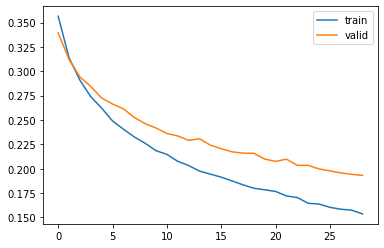

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

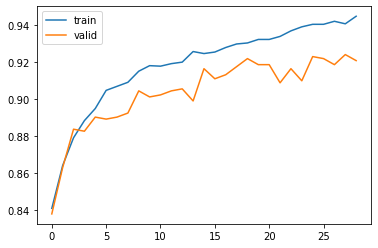

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.953125

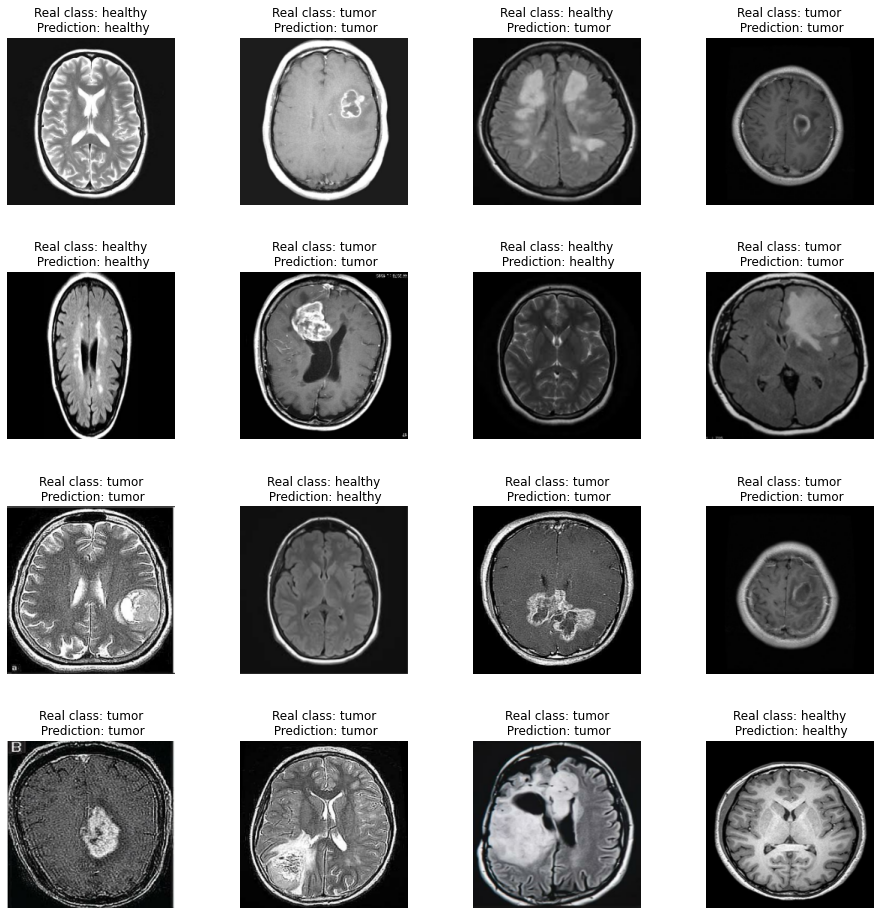

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')
plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

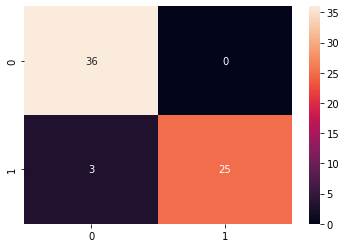

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32, target_names=class_names)
sns.heatmap(cf, annot=True)
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        36
           1       1.00      0.89      0.94        28

    accuracy                           0.95        64
   macro avg       0.96      0.95      0.95        64
weighted avg       0.96      0.95      0.95        64



## Mobilenet_v2 - model with data augmentation

In [23]:
input_shape = (224, 224, 3)

In [24]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.mobilenet_v2.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(1)(x)

model_2 = keras.Model(input, output)

model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0   

In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 30
patience = 2

In [27]:
history_2 = model_2.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
58/58 [==============================] - 78s 1s/step - loss: 0.5025 - binary_accuracy: 0.7405 - val_loss: 0.3625 - val_binary_accuracy: 0.8489
Epoch 2/30
58/58 [==============================] - 75s 1s/step - loss: 0.3262 - binary_accuracy: 0.8598 - val_loss: 0.2873 - val_binary_accuracy: 0.9011
Epoch 3/30
58/58 [==============================] - 74s 1s/step - loss: 0.2696 - binary_accuracy: 0.8924 - val_loss: 0.2520 - val_binary_accuracy: 0.8978
Epoch 4/30
58/58 [==============================] - 74s 1s/step - loss: 0.2499 - binary_accuracy: 0.9000 - val_loss: 0.2275 - val_binary_accuracy: 0.9098
Epoch 5/30
58/58 [==============================] - 74s 1s/step - loss: 0.2219 - binary_accuracy: 0.9185 - val_loss: 0.2143 - val_binary_accuracy: 0.9076
Epoch 6/30
58/58 [==============================] - 75s 1s/step - loss: 0.2176 - binary_accuracy: 0.9215 - val_loss: 0.2066 - val_binary_accuracy: 0.9065
Epoch 7/30
58/58 [==============================] - 74s 1s/step - loss: 0.20

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

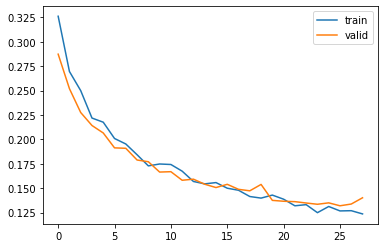

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

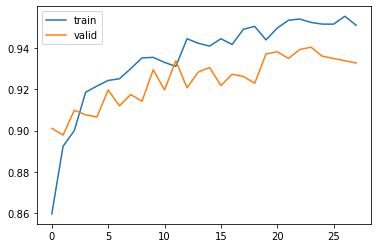

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [32]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.96875

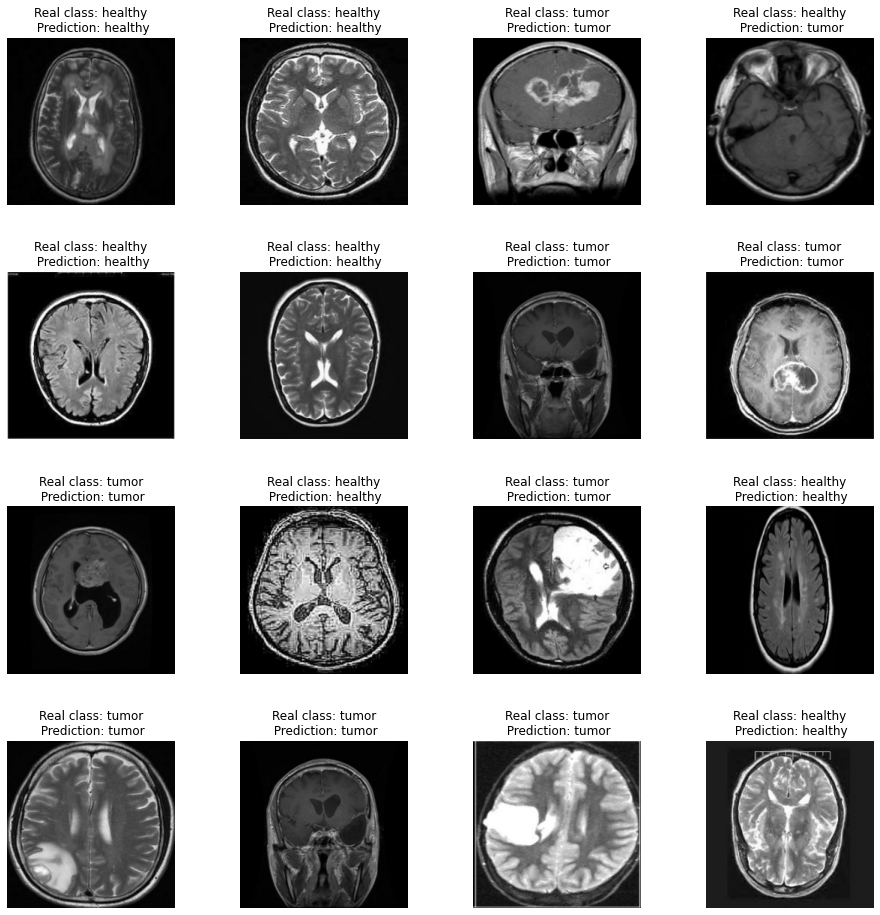

In [33]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [34]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

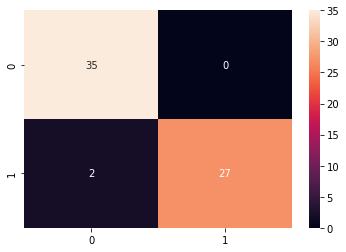

In [35]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32, target_names=class_names)
sns.heatmap(cf, annot=True)
plt.show();

In [36]:
print(classification_report(y_val_2, y_pred_2_binary))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.93      0.96        29

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



## Mobilenet_v2 - model with data augmentation + additional layers

In [37]:
input_shape = (224, 224, 3)

In [39]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.mobilenet_v2.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(320)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_3 = keras.Model(input, output)

model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast_2 (RandomCon (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation_2 (Random (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0   

In [40]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [43]:
epochs = 30
patience = 2

In [44]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
58/58 [==============================] - 74s 1s/step - loss: 0.2009 - binary_accuracy: 0.9228 - val_loss: 0.1388 - val_binary_accuracy: 0.9511
Epoch 2/30
58/58 [==============================] - 74s 1s/step - loss: 0.1657 - binary_accuracy: 0.9321 - val_loss: 0.1264 - val_binary_accuracy: 0.9467
Epoch 3/30
58/58 [==============================] - 75s 1s/step - loss: 0.1372 - binary_accuracy: 0.9443 - val_loss: 0.1201 - val_binary_accuracy: 0.9467
Epoch 4/30
58/58 [==============================] - 75s 1s/step - loss: 0.1380 - binary_accuracy: 0.9457 - val_loss: 0.1149 - val_binary_accuracy: 0.9500
Epoch 5/30
58/58 [==============================] - 75s 1s/step - loss: 0.1240 - binary_accuracy: 0.9481 - val_loss: 0.1322 - val_binary_accuracy: 0.9413
Epoch 6/30
58/58 [==============================] - 75s 1s/step - loss: 0.1457 - binary_accuracy: 0.9440 - val_loss: 0.1412 - val_binary_accuracy: 0.9478


#### Patience increase

In [60]:
epochs = 30
patience = 3

In [61]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
58/58 [==============================] - 75s 1s/step - loss: 0.1321 - binary_accuracy: 0.9454 - val_loss: 0.1517 - val_binary_accuracy: 0.9457
Epoch 2/30
58/58 [==============================] - 74s 1s/step - loss: 0.1310 - binary_accuracy: 0.9516 - val_loss: 0.1410 - val_binary_accuracy: 0.9402
Epoch 3/30
58/58 [==============================] - 74s 1s/step - loss: 0.1195 - binary_accuracy: 0.9543 - val_loss: 0.1710 - val_binary_accuracy: 0.9261
Epoch 4/30
58/58 [==============================] - 74s 1s/step - loss: 0.1156 - binary_accuracy: 0.9571 - val_loss: 0.1438 - val_binary_accuracy: 0.9337
Epoch 5/30
58/58 [==============================] - 74s 1s/step - loss: 0.1262 - binary_accuracy: 0.9500 - val_loss: 0.1388 - val_binary_accuracy: 0.9370
Epoch 6/30
58/58 [==============================] - 75s 1s/step - loss: 0.1154 - binary_accuracy: 0.9535 - val_loss: 0.1382 - val_binary_accuracy: 0.9435
Epoch 7/30
58/58 [==============================] - 75s 1s/step - loss: 0.10

In [62]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

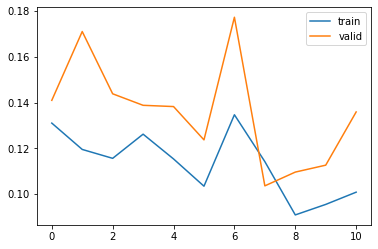

In [63]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

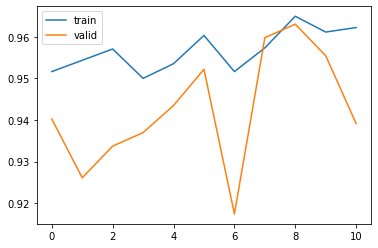

In [64]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [65]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.984375

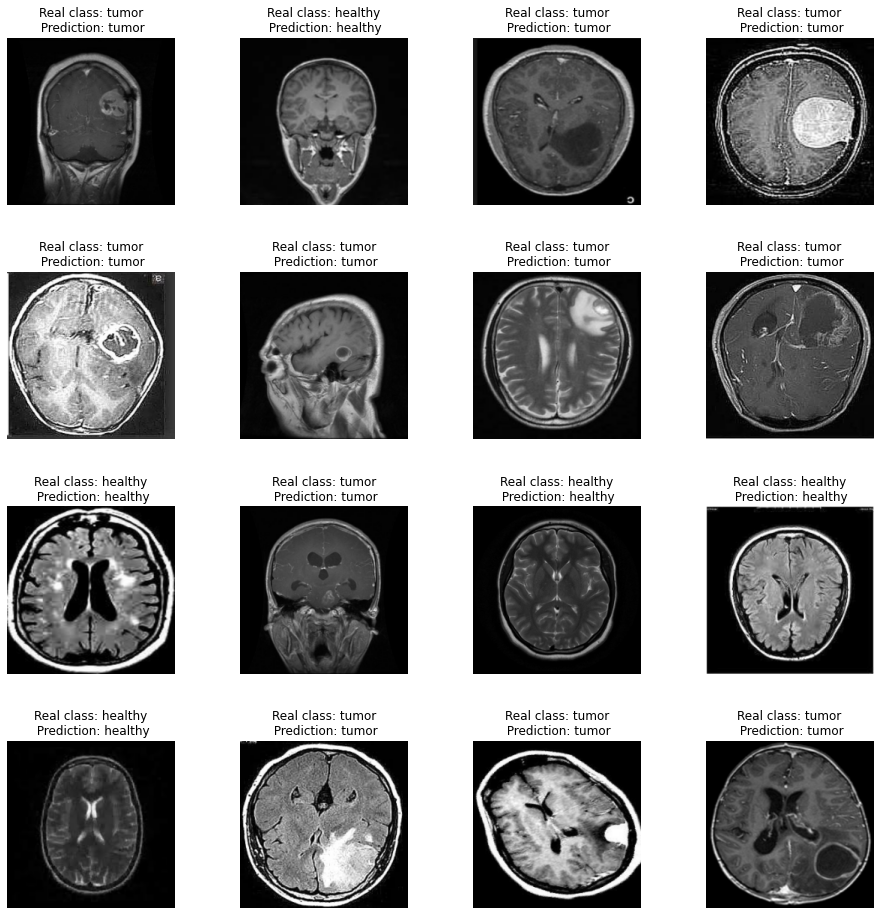

In [66]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [67]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

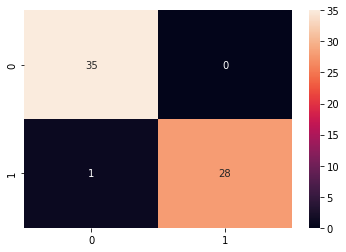

In [68]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32, target_names=class_names)
sns.heatmap(cf, annot=True)
plt.show();

In [69]:
print(classification_report(y_val_3, y_pred_3_binary))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.97      0.98        29

    accuracy                           0.98        64
   macro avg       0.99      0.98      0.98        64
weighted avg       0.98      0.98      0.98        64



## Inception_v3 - simple model

In [70]:
input_shape = (256, 256, 3)

In [71]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(input, training=False)
output = keras.layers.Dense(1)(x)

model_4 = keras.Model(input, output)

model_4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [88]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [89]:
epochs = 30
patience = 5

In [90]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
58/58 [==============================] - 189s 3s/step - loss: 0.5519 - binary_accuracy: 0.8114 - val_loss: 0.4194 - val_binary_accuracy: 0.8478
Epoch 2/30
58/58 [==============================] - 182s 3s/step - loss: 0.3382 - binary_accuracy: 0.8601 - val_loss: 0.3604 - val_binary_accuracy: 0.8402
Epoch 3/30
58/58 [==============================] - 183s 3s/step - loss: 0.3468 - binary_accuracy: 0.8571 - val_loss: 0.3631 - val_binary_accuracy: 0.8424
Epoch 4/30
58/58 [==============================] - 183s 3s/step - loss: 0.3276 - binary_accuracy: 0.8671 - val_loss: 0.3215 - val_binary_accuracy: 0.8652
Epoch 5/30
58/58 [==============================] - 183s 3s/step - loss: 0.3084 - binary_accuracy: 0.8745 - val_loss: 0.4017 - val_binary_accuracy: 0.8054
Epoch 6/30
58/58 [==============================] - 184s 3s/step - loss: 0.3562 - binary_accuracy: 0.8554 - val_loss: 0.3999 - val_binary_accuracy: 0.8141
Epoch 7/30
58/58 [==============================] - 184s 3s/step - los

In [91]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

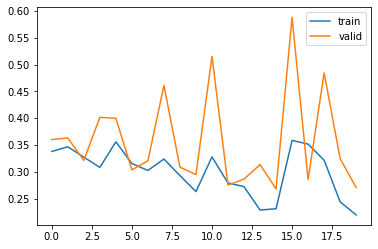

In [92]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

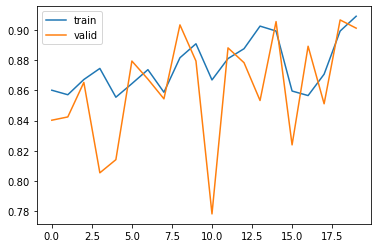

In [93]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [94]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.9375

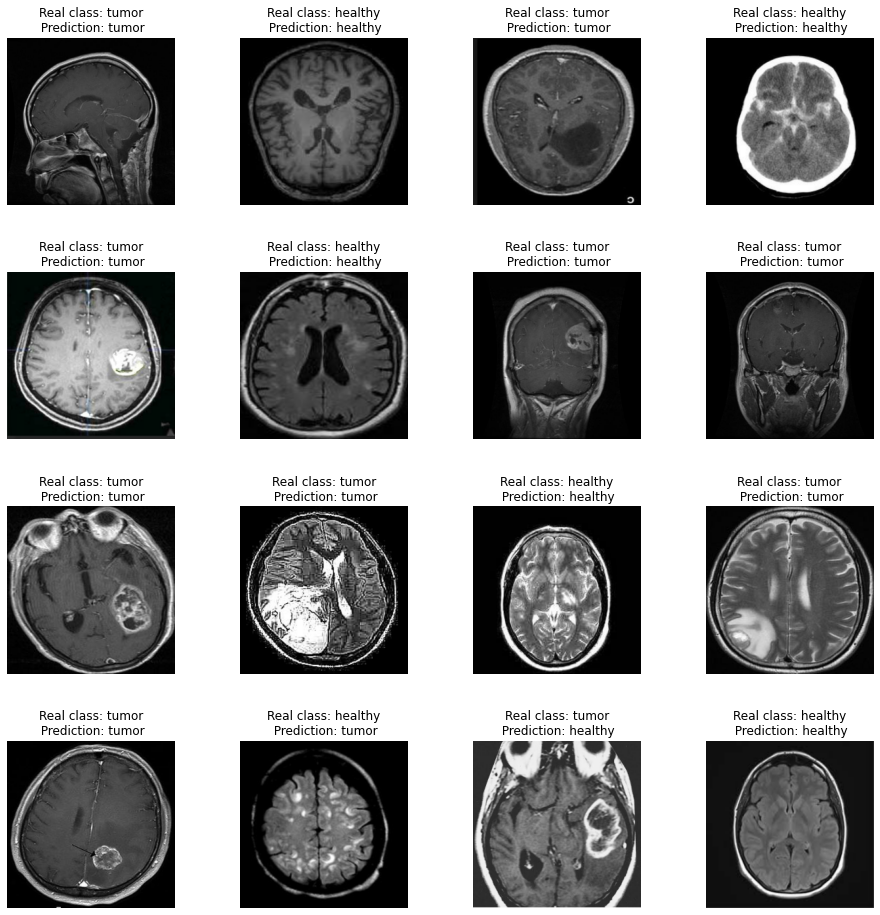

In [95]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [96]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

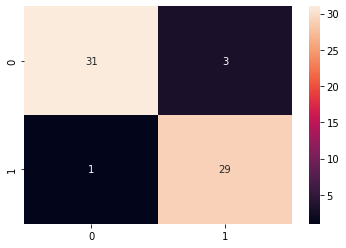

In [97]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32, target_names=class_names)
sns.heatmap(cf, annot=True)
plt.show();

In [98]:
print(classification_report(y_val_4, y_pred_4_binary))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        34
           1       0.91      0.97      0.94        30

    accuracy                           0.94        64
   macro avg       0.94      0.94      0.94        64
weighted avg       0.94      0.94      0.94        64



## Inception_v3 model - with data augmentation

In [99]:
input_shape = (256, 256, 3)

In [100]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.inception_v3.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(x, training=False)
output = keras.layers.Dense(1)(x)

model_5 = keras.Model(input, output)

model_5.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
random_contrast_4 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_4 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049

In [101]:
model_5.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [102]:
epochs = 30
patience = 5

In [103]:
history_5 = model_5.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
58/58 [==============================] - 190s 3s/step - loss: 0.5047 - binary_accuracy: 0.7315 - val_loss: 0.4301 - val_binary_accuracy: 0.8174
Epoch 2/30
58/58 [==============================] - 187s 3s/step - loss: 0.3712 - binary_accuracy: 0.8310 - val_loss: 0.3678 - val_binary_accuracy: 0.8467
Epoch 3/30
58/58 [==============================] - 186s 3s/step - loss: 0.3331 - binary_accuracy: 0.8557 - val_loss: 0.3563 - val_binary_accuracy: 0.8652
Epoch 4/30
58/58 [==============================] - 187s 3s/step - loss: 0.2989 - binary_accuracy: 0.8723 - val_loss: 0.3085 - val_binary_accuracy: 0.8663
Epoch 5/30
58/58 [==============================] - 186s 3s/step - loss: 0.2826 - binary_accuracy: 0.8842 - val_loss: 0.2947 - val_binary_accuracy: 0.8783
Epoch 6/30
58/58 [==============================] - 186s 3s/step - loss: 0.2684 - binary_accuracy: 0.8889 - val_loss: 0.2992 - val_binary_accuracy: 0.8924
Epoch 7/30
58/58 [==============================] - 186s 3s/step - los

In [104]:
history_5.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

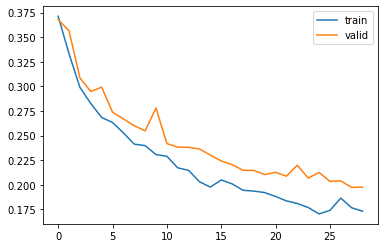

In [105]:
plt.plot(history_5.history['loss'][1:])
plt.plot(history_5.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

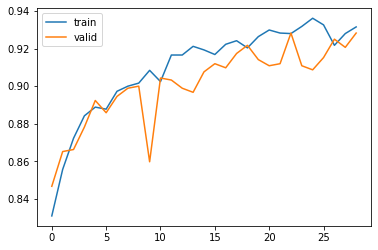

In [106]:
plt.plot(history_5.history['binary_accuracy'][1:])
plt.plot(history_5.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [107]:
x_val_5, y_val_5 = list(tfds.as_numpy(ds_val))[0]
y_pred_5 = model_5.predict(x_val_5)
sum((y_pred_5[:, 0] > 0) == y_val_5) / len(y_val_5)

0.953125

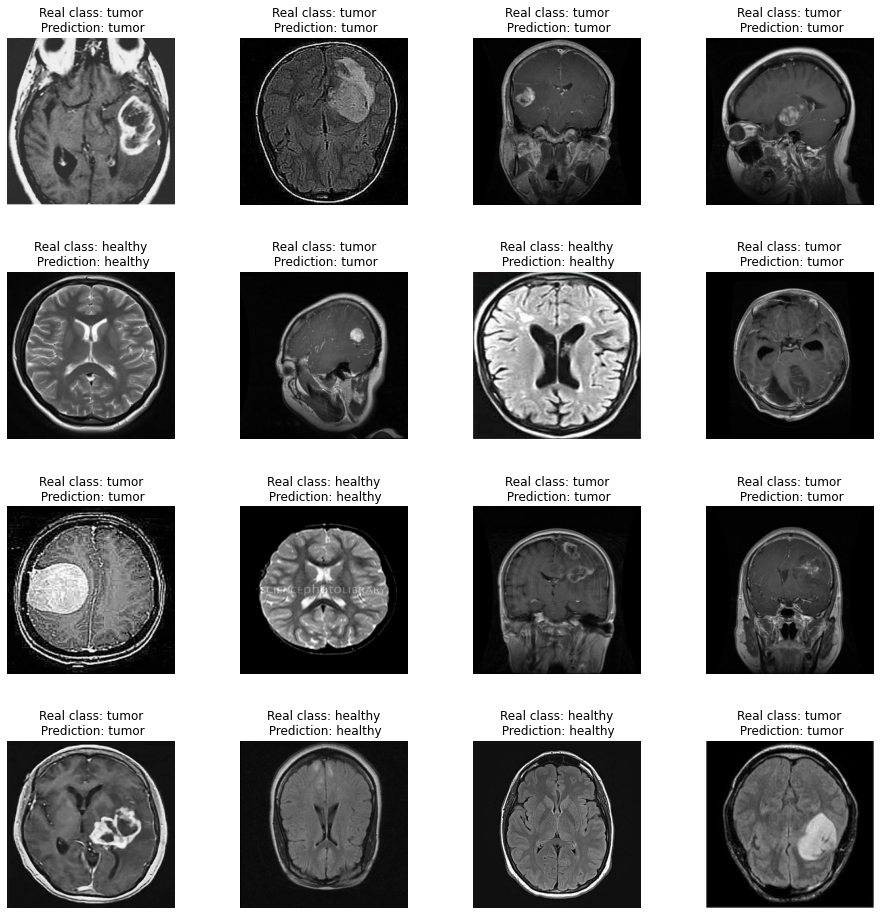

In [108]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_5[i].astype('int32'))
    
    real_y = 'healthy' if y_val_5[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_5[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [109]:
y_pred_5_binary = [1 if y > 0 else 0 for y in y_pred_5]

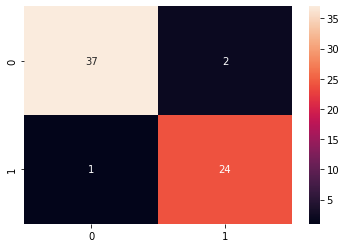

In [110]:
cf = tf.math.confusion_matrix(y_val_5, y_pred_5_binary, dtype=tf.dtypes.int32, target_names=class_names)
sns.heatmap(cf, annot=True)
plt.show();

In [111]:
print(classification_report(y_val_5, y_pred_5_binary))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96        39
           1       0.92      0.96      0.94        25

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64



## Inception_v3 - model with data augmentation + additional layers

In [13]:
input_shape = (256, 256, 3)

In [18]:
input = keras.layers.Input(input_shape, dtype=tf.float32)
x = keras.applications.inception_v3.preprocess_input(input)
x = keras.layers.experimental.preprocessing.RandomContrast((0.1, 0.6), seed=404)(x)
x = keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2, fill_mode='nearest', seed=404)(x)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(x, training=False)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_6 = keras.Model(input, output)

model_6.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 256, 256, 3)       0         
_________________________________________________________________
random_contrast_1 (RandomCon (None, 256, 256, 3)       0         
_________________________________________________________________
random_translation_1 (Random (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               5245

In [19]:
model_6.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [20]:
epochs = 30
patience = 5

In [21]:
history_6 = model_6.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/30
58/58 [==============================] - 478s 8s/step - loss: 0.8705 - binary_accuracy: 0.7476 - val_loss: 0.3318 - val_binary_accuracy: 0.8554
Epoch 2/30
58/58 [==============================] - 507s 9s/step - loss: 0.3210 - binary_accuracy: 0.8685 - val_loss: 0.4002 - val_binary_accuracy: 0.8598
Epoch 3/30
58/58 [==============================] - 523s 9s/step - loss: 0.2813 - binary_accuracy: 0.8774 - val_loss: 0.2654 - val_binary_accuracy: 0.9033
Epoch 4/30
58/58 [==============================] - 542s 9s/step - loss: 0.2479 - binary_accuracy: 0.8981 - val_loss: 0.4173 - val_binary_accuracy: 0.8522
Epoch 5/30
58/58 [==============================] - 574s 10s/step - loss: 0.2552 - binary_accuracy: 0.8875 - val_loss: 0.2208 - val_binary_accuracy: 0.9152
Epoch 6/30
58/58 [==============================] - 614s 11s/step - loss: 0.1966 - binary_accuracy: 0.9204 - val_loss: 0.2061 - val_binary_accuracy: 0.9109
Epoch 7/30
58/58 [==============================] - 616s 11s/step - 

In [22]:
history_6.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

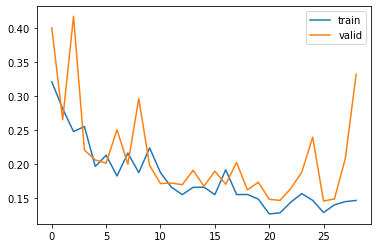

In [23]:
plt.plot(history_6.history['loss'][1:])
plt.plot(history_6.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

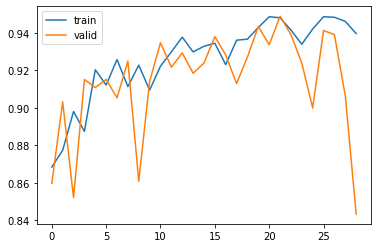

In [24]:
plt.plot(history_6.history['binary_accuracy'][1:])
plt.plot(history_6.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [25]:
x_val_6, y_val_6 = list(tfds.as_numpy(ds_val))[0]
y_pred_6 = model_6.predict(x_val_6)
sum((y_pred_6[:, 0] > 0) == y_val_6) / len(y_val_6)

0.90625

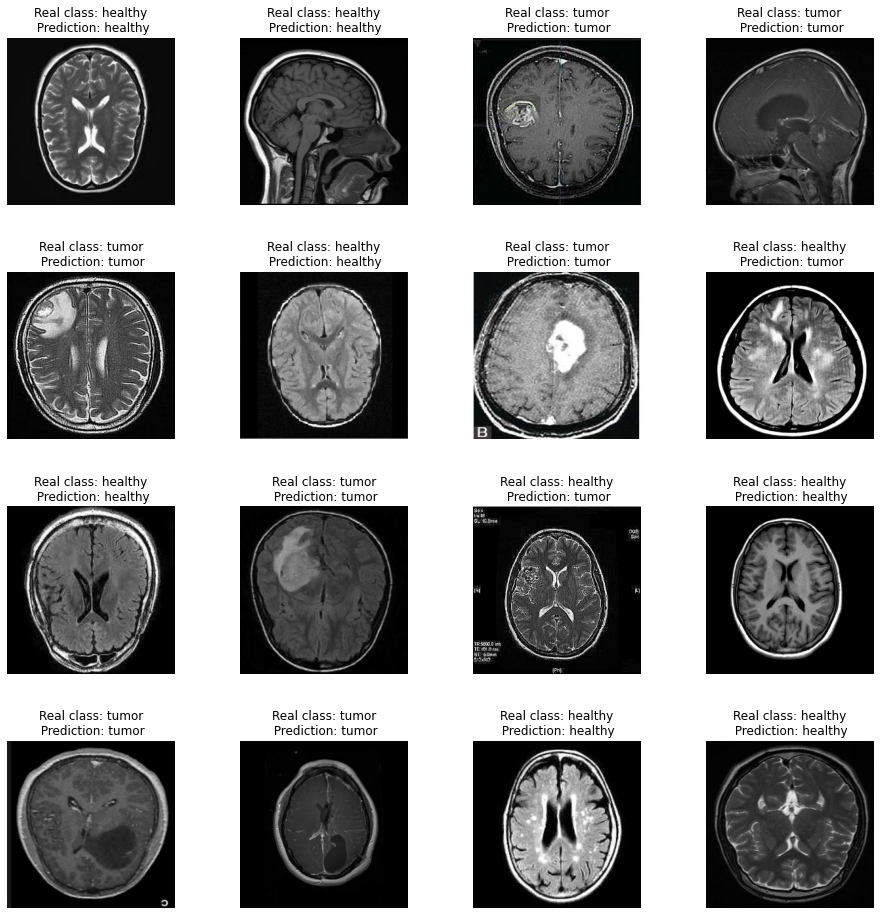

In [26]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_6[i].astype('int32'))
    
    real_y = 'healthy' if y_val_6[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_6[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [27]:
y_pred_6_binary = [1 if y > 0 else 0 for y in y_pred_6]

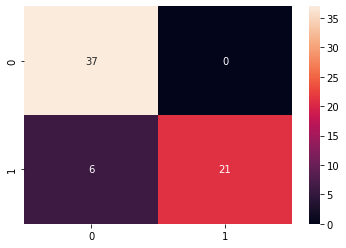

In [28]:
cf = tf.math.confusion_matrix(y_val_6, y_pred_6_binary, dtype=tf.dtypes.int32, target_names=class_names)
sns.heatmap(cf, annot=True)
plt.show();

In [29]:
print(classification_report(y_val_6, y_pred_6_binary))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        37
           1       1.00      0.78      0.88        27

    accuracy                           0.91        64
   macro avg       0.93      0.89      0.90        64
weighted avg       0.92      0.91      0.90        64

